In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
in_feature = 16
out_feature = 8
bias = True
cycle = 128
rounding = "round"

total_bit = 16
input_int_bit = 3
input_fra_bit = total_bit - input_int_bit

input = ((torch.rand(256, in_feature) - 0.5) * 2**(2*input_int_bit)).round().div(2**(input_int_bit)).to(device)

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
fc_o = fc(input)

ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
ufc_o = ufc(input)

(fc_o - ufc_o).abs().mean().backward()

diff max: tensor(0.0818, device='cuda:0', grad_fn=<MaxBackward1>)
diff min: tensor(-0.0892, device='cuda:0', grad_fn=<MinBackward1>)
diff mean: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)


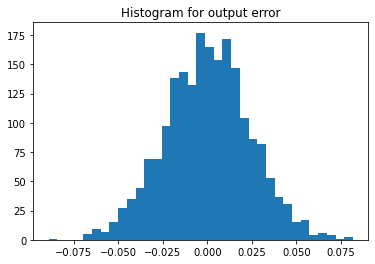

In [5]:
diff = (ufc_o - fc_o)
print("diff max:", diff.max())
print("diff min:", diff.min())
print("diff mean:", diff.mean())

fig = plt.hist(diff.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for output error")
plt.show()

diff grad max: tensor(0.2457, device='cuda:0')
diff grad min: tensor(-0.2369, device='cuda:0')
diff grad mean: tensor(-0.0141, device='cuda:0')


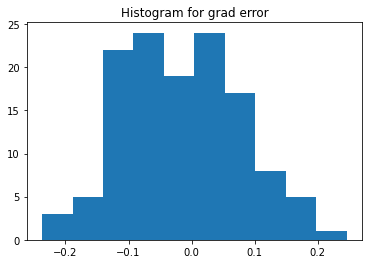

In [6]:
diff_grad = (ufc.weight.grad - fc.weight.grad)
print("diff grad max:", diff_grad.max())
print("diff grad min:", diff_grad.min())
print("diff grad mean:", diff_grad.mean())

fig = plt.hist(diff_grad.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for grad error")
plt.show()

In [7]:
print(ufc_o)

tensor([[-1.5121,  1.2241, -0.9702,  ..., -0.6745, -0.0732, -1.6021],
        [-1.7152,  2.3335, -0.0795,  ..., -2.8620, -1.6904, -0.2037],
        [ 1.3864, -1.8775,  0.7486,  ...,  2.4192,  0.5206, -0.2583],
        ...,
        [-0.2699,  3.1694, -1.3764,  ...,  0.6302,  1.0987, -0.2037],
        [ 0.0114, -2.1587,  1.8189,  ...,  0.0286,  0.9424, -1.5865],
        [-0.6683,  1.4819,  0.7642,  ..., -3.2839,  0.3018, -0.0630]],
       device='cuda:0', grad_fn=<HUBLinearFunctionBackward>)
